In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
from coffea import hist


from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

In [4]:
web_dir = '/publicweb/m/mreid/iDM_AN_Plots/MetTriggerStudyv19'

# Define functions

In [5]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [49]:
import scipy.special
from scipy.optimize import curve_fit, fsolve
from scipy import odr

def fsigmoid(z, p0, p1):
    return 1.0 / (1.0 + np.exp(-p0*(z-p1)))
def ferf_cf(z, p0, p1, p2, p3):
    return p2 + p3*scipy.special.erf((z-p0)/p1)
def f98percentile_cf(z, p):
    return ferf_cf(z, *p) - (p[2]+p[3])*0.98
def ferf_odr(p, z):
    return p[2] + p[3]*scipy.special.erf((z-p[0])/p[1])
def f98percentile_odr(z, p):
    return ferf_odr(p, z) - (p[2]+p[3])*0.98

def make_plot(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for (l1,x),(l2,w) in zip(objs[event_selection][objs[event_selection]['fired0'] == True][variable].iteritems(),objs[event_selection][objs[event_selection]['fired0'] == True]['wgt'].iteritems()):
        h0.Fill(x,w)
    for (l1,x),(l2,w) in zip(objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)][variable].iteritems(),objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)]['wgt'].iteritems()):
        h1.Fill(x,w)

    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    print(data['y'])
    data['x'] = data['x'][((np.isnan(data['yerr'][1])==False))]
    data['y'] = data['y'][((np.isnan(data['yerr'][1])==False))]
    print(data['yerr'][1])
    data['yerr2'] = [data['yerr'][0][((np.isnan(data['yerr'][1])==False))],data['yerr'][1][((np.isnan(data['yerr'][1])==False))]]
    data['yerr2'][1][data['yerr2'][1]==0] = 0.1
    data['yerr2'][0][data['yerr2'][0]==0] = 0.1
    data['yerr'] = data['yerr2']
    xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
    ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'], 
                label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    
    ax.set_title(f'Trigger efficiency as a function of MET')
    ax.set_xlabel('MET pT [GeV]')
    ax.set_ylabel('Trigger efficiency')
    ax.set_ylim((0.7,1))
    
    return data
                
def make_plot_scan(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for (l1,x),(l2,w) in zip(objs[event_selection][objs[event_selection]['fired0'] == True][variable].iteritems(),objs[event_selection][objs[event_selection]['fired0'] == True]['wgt'].iteritems()):
        h0.Fill(x,w)
    for (l1,x),(l2,w) in zip(objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)][variable].iteritems(),objs[event_selection][(objs[event_selection]['fired'] == True) & (objs[event_selection]['fired0'] == True)]['wgt'].iteritems()):
        h1.Fill(x,w)

    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    print(data['y'])
    data['x'] = data['x'][((np.isnan(data['yerr'][1])==False))]
    data['y'] = data['y'][((np.isnan(data['yerr'][1])==False))]
    print(data['yerr'][1])
    data['yerr2'] = [data['yerr'][0][((np.isnan(data['yerr'][1])==False))],data['yerr'][1][((np.isnan(data['yerr'][1])==False))]]
    data['yerr2'][1][data['yerr2'][1]==0] = 0.1
    data['yerr2'][0][data['yerr2'][0]==0] = 0.1
    data['yerr'] = data['yerr2']
    
    return data

def make_plot_fit_cf(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
                
    popt, pcov = curve_fit(ferf_cf, data['x'][minbin:maxbin], data['y'][minbin:maxbin], p0=[130,40,1,1],sigma=data['yerr'][1][minbin:maxbin],
                          bounds=([100,30,-10,-10],[250,100,10,10]))
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {pcov[i,i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_cf, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_cf(fit_range, *popt), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.legend()
    objs[event_selection]['cf_98'] = percentile98[0]
    objs[event_selection]['cf_eff'] = popt[2]+popt[3]  
    
    chi = (data['y'][minbin:maxbin] - ferf_cf(data['x'][minbin:maxbin], *popt)) / data['yerr'][1][minbin:maxbin]
    chi2 = (chi ** 2).sum()
    dof = len(data['x'][minbin:maxbin]) - len(popt)
    objs[event_selection]['cf_chi2'] = (chi2 / dof)
   
          
def make_plot_fit_odr(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    
    model = odr.Model(ferf_odr)
    xerror = np.repeat(data['x'][1]-data['x'][0], len(data['x'])-minbin)
    real_data = odr.RealData(data['x'][minbin:maxbin], data['y'][minbin:maxbin], sx=xerror, sy=data['yerr'][0][minbin:maxbin])
    odr_obj = odr.ODR(real_data, model, beta0=[132, 36, 0.5, 0.5])
    #odr_obj = odr.ODR(real_data, model, beta0=[130, 30, 0.5, 0.5])
    out = odr_obj.run()
    
    popt = out.beta
    perr = out.sd_beta
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {perr[i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_odr, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_odr(popt, fit_range), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.set_title(f'Trigger efficiency as a function of MET (odr fit)')
    
    ax.legend()
    objs[event_selection]['odr_98'] = percentile98[0]
    objs[event_selection]['odr_eff'] = popt[2]+popt[3]
    objs[event_selection]['odr_chi2'] = out.res_var
          
          
def scan_plot(ax, sample, objs, variable, plot_props, event_selection='enrich'):
    data = make_plot_scan(ax, sample, objs, variable, plot_props, event_selection)

    #minbin = 0 if data['y'][0] < 0.1 else 1
    #maxbin = -1
    
    per95 =0
    per98 =0
    pass95 = False
    pass98 = False
    for bins in range(len(data['x'])-2):
        #print(bins)
        avg = (data['y'][bins]+data['y'][bins+1]+data['y'][bins+2])/3
        if ((not pass95) and (avg>0.90)): 
            pass95 = True
            per95 = bins+1
        if ((not pass98) and (avg>0.95)): 
            pass98 = True
            per98 = bins+1
            break

         
    print(fr"90:{data['x'][per95]}:{data['y'][per95]}:{per95}")
    print(fr"98:{data['x'][per98]}:{data['y'][per98]}:{per98}")
    if per95 != 0.0:
        plt.axvline(x=data['x'][per95],linestyle='--',color = objs['color'])
    if per98 != 0.0:
        plt.axvline(x=data['x'][per98],linestyle=':',color = objs['color'])
    objs['re-label'] = objs['label'] + fr" (90:{data['x'][per95]}; 95:{data['x'][per98]})"
    print(data['x'])
    data['x'] = data['x'][((np.isnan(data['yerr'][1])==False))]
    data['y'] = data['y'][((np.isnan(data['yerr'][1])==False))]
    #xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
    xerr = np.diff(plot_props['axis'])/2
    print(xerr)
    ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'], 
                label=f'{props["re-label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    
    ax.set_title(f'Trigger efficiency as a function of MET')
    ax.set_xlabel('MET pT [GeV]')
    ax.set_ylabel('Trigger efficiency')
    ax.set_ylim((0.89,1))
                   
    ax.legend()
    objs[event_selection]['scan_98'] = data['y'][per98]
    objs[event_selection]['scan_90'] = data['y'][per95]
    #objs[event_selection]['odr_chi2'] = out.res_var

# Load data

In [ ]:
Combo_samples = {
    'WMuNu': {
        'label': 'WMuNu',
        'color': 'C0'
    },
    'MC': {
        'label': 'MC',
        'color': 'C1'
    },
    'Data': {
        'label': 'Data',
        'color': 'C4'
    }
}


In [ ]:
full_samples = {
    'WMuNu': {
        'label': 'WMuNu',
        'color': 'C0',
        'dir': ['WToMuNu_M-200_TuneCP5_13TeV-pythia8/crab_METTrigEffiv8_WMuNu/190820_200633/0000'],
        'xsec': [7.265],
        'filename': []
    },
    'TT': {
        'label': 'TT',
        'color': 'C1',
        'dir': ['TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_TTJets/190820_200357/0000',
                'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv8_TTTo2L2Nu/190820_200119/0000',
                'TT_DiLept_TuneCP5_13TeV-amcatnlo-pythia8/crab_METTrigEffiv8_TT_diLept/190820_200543/0000'
               ],
        'xsec': [491.4,
                 687.1,
                 72.48                
                ],
        'filename': []
    },
    'WJets': {
        'label': 'WJets',
        'color': 'C2',
        'dir': ['WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-70To100/190820_200813/0000',                
                'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-100To200/190826_144257/0000',
                'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-200To400/190826_144438/0000',
                'WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-400To600/190820_201053/0000',
                'WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-600To800/190820_200027/0000',   
                'WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-800To1200/190820_195934/0000',
                'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-1200To2500/190820_195755/0000',
                'WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/crab_METTrigEffiv8_WJetsToLNu_HT-2500ToInf/190826_144526/0000'
            ],
        'xsec':[1288.0000,
                1393.0000,
                405.8000,
                57.7900,
                12.9100,
                5.4470,
                1.0830,
                0.0080     
                ],
        'filename': []
    },
    'DiBoson': {
        'label': 'DiBoson',
        'color': 'C3',
        'dir': ['ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_METTrigEffiv8_ZZTo2L2Nu/190820_195842/0000',
                'ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_METTrigEffiv8_ZZTo2L2Nu_ext2/190826_144619/0000',
                'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv8_WZTo3LNu/190820_200721/0000',
                'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_METTrigEffiv8_WWTo2L2Nu/190820_200952/0000',
                'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_METTrigEffiv8_WWJJToLNuLNu/190820_200209/0000'
                ],
        'xsec':[0.6008,
                0.6008, #double check later
                4.6580,
                11.08,
                2.1630
                ],
        'filename': []
    },
     'Data': {
         'label': 'Data',
         'color': 'C4',
         'dir': ['SingleMuon/crab_METTrigEffiv8_singleMu_RunA_Sep/190820_201510/0000',
                 'SingleMuon/crab_METTrigEffiv8_singleMu_RunB_Sep/190820_201740/0000',
                 'SingleMuon/crab_METTrigEffiv8_singleMu_RunC_Sep/190820_201652/0000',
                 'SingleMuon/crab_METTrigEffiv8_singleMu_RunD_Jan/190820_201556/0000',
                 'SingleMuon/crab_METTrigEffiv8_singleMu_RunD_Jan/190820_201556/0001'
                 ],
         'xsec':[1,1,1,1,1],
         'filename': []
     }
}


In [7]:
Data_samples = {
     'Data': {
         'label': 'Data',
         'color': 'C1',
         'dir': [
                 'SingleMuon/crab_METTrigEffiv10singleMu_RunA_Sep/190916_183337/0000',
                 'SingleMuon/crab_METTrigEffiv10singleMu_RunB_Sep/190916_183536/0000',
                 'SingleMuon/crab_METTrigEffiv10singleMu_RunC_Sep/190916_183440/0000',
                 'SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000',
                 'SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0001'
                 ],
         'xsec':[1,1,1,1,1],
         'filename': []
     }
}



In [8]:
Comp_Data = {
#     '120v50': {
#         'label': '120MET 50Ref',
#         'color': 'C0'
#     },
    '120v24Iso': {
        'label': '120MET 24IsoRef',
        'color': 'C1'
    },
#     '130v50': {
#         'label': '130MET 50Ref',
#         'color': 'C2'
#     },
    '130v24Iso': {
        'label': '130MET 24IsoRef',
        'color': 'C3'
    },
#     '140v50': {
#         'label': '140MET 50Ref',
#         'color': 'C4'
#     },
    '140v24Iso': {
        'label': '140MET 24IsoRef',
        'color': 'C5'
    }
}


In [9]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")
redirector = 'root://cmseos.fnal.gov'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14'
#sample_list = [Di_samples,W_samples,TT_samples]
sample_list = [Data_samples]
for samples in sample_list:
    for sample, objs in samples.items():
        for sample_index,(xsec, dirs) in enumerate(zip(objs['xsec'],objs['dir'])):
            print(dirs,xsec,sample_index)
    #dirs = objs['dir']
            status, listing = xrdfs.dirlist(f'{basedir}/{dirs}', DirListFlags.STAT)
        #print(listing)
            for file in listing:
                if '.root' in file.name:
                    samples[sample]['filename'].append((f'{redirector}/{basedir}/{dirs}/{file.name}',xsec,sample_index))


SingleMuon/crab_METTrigEffiv10singleMu_RunA_Sep/190916_183337/0000 1 0
SingleMuon/crab_METTrigEffiv10singleMu_RunB_Sep/190916_183536/0000 1 1
SingleMuon/crab_METTrigEffiv10singleMu_RunC_Sep/190916_183440/0000 1 2
SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000 1 3
SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0001 1 4


In [10]:
%%time
luminosity = 59.97 # 1/fb, 2018
MAX_FILES=None
sample_list = [Data_samples]

for samples in sample_list:
    for sample, objs in samples.items():
#         objs['enrich'] = []
#         objs['enrich1'] = []
#         objs['enrich2'] = []
       
        objs['enrichx'] = []
        objs['enrichx1'] = []
        objs['enrichx2'] = []
       
        print(objs['label'])
      #  if objs['label'] is 'Data':
      #      continue
        sample_counter=0
        sum_gen_wgt={}
        sum_gen_wgtx={}
        sum_gen_wgt1={}
        sum_gen_wgtx1={}
        sum_gen_wgt2={}
        sum_gen_wgtx2={}
        file_counter = 1
        max_samples=0
        for filex,xsec,sample_index in objs['filename'][slice(0,MAX_FILES)]:
            if file_counter % 10 == 1:
                total = len(objs['filename'][slice(0,MAX_FILES)])
                print(f'Reading file {file_counter} of {total}')
            file_counter +=1
        
            file = uproot.open(filex)
#             objs['trig_tree'] = file['RECO_dsa50/MetTrigSelfEffiForMuTrack']
#             objs['weight_tree'] = file['RECO_dsa50/GenWeight']
            objs['trig_treex'] = file['RECO_dsaIso/MetTrigSelfEffiForMuTrack']
            objs['weight_treex'] = file['RECO_dsaIso/GenWeight']
#             objs['trig_tree1'] = file['RECO_dsa50_130/MetTrigSelfEffiForMuTrack']
#             objs['weight_tree1'] = file['RECO_dsa50_130/GenWeight']
            objs['trig_treex1'] = file['RECO_dsaIso_130/MetTrigSelfEffiForMuTrack']
            objs['weight_treex1'] = file['RECO_dsaIso_130/GenWeight']
#             objs['trig_tree2'] = file['RECO_dsa50_140/MetTrigSelfEffiForMuTrack']
#             objs['weight_tree2'] = file['RECO_dsa50_140/GenWeight']
            objs['trig_treex2'] = file['RECO_dsaIso_140/MetTrigSelfEffiForMuTrack']
            objs['weight_treex2'] = file['RECO_dsaIso_140/GenWeight']
            skip = False
            skipx = False
            skip1 = False
            skipx1 = False
            skip2 = False
            skipx2 = False
            
#             try:
#                 sum_gen_wgt.setdefault(sample_index,0)
#                 objs['weight'] = objs['weight_tree'].pandas.df(['genwgt'])
#                 sum_gen_wgt[sample_index] += objs['weight']['genwgt'].sum()
#                 #objs['weightx'] = objs['weight_treex'].pandas.df(['genwgt'])
#                 #sum_gen_wgt[sample_index] += objs['weightx']['genwgt'].sum()
             
#             except:
#                 print("skipped weight: ",filex)
#                 skip1 = True
#                 #continue
            try:
                sum_gen_wgtx.setdefault(sample_index,0)
                objs['weightx'] = objs['weight_treex'].pandas.df(['genwgt'])
                sum_gen_wgtx[sample_index] += objs['weightx']['genwgt'].sum()
             
            except:
                print("skipped weightx: ",filex)
                skipx = True
#             try:
#                 sum_gen_wgt1.setdefault(sample_index,0)
#                 objs['weight1'] = objs['weight_tree1'].pandas.df(['genwgt'])
#                 sum_gen_wgt1[sample_index] += objs['weight1']['genwgt'].sum()
             
#             except:
#                 print("skipped weight1: ",filex)
#                 skip1 = True
            try:
                sum_gen_wgtx1.setdefault(sample_index,0)
                objs['weightx1'] = objs['weight_treex1'].pandas.df(['genwgt'])
                sum_gen_wgtx1[sample_index] += objs['weightx1']['genwgt'].sum()
             
            except:
                print("skipped weightx1: ",filex)
                skipx1 = True
#             try:
#                 sum_gen_wgt2.setdefault(sample_index,0)
#                 objs['weight2'] = objs['weight_tree2'].pandas.df(['genwgt'])
#                 sum_gen_wgt2[sample_index] += objs['weight2']['genwgt'].sum()
             
#             except:
#                 print("skipped weight2: ",filex)
#                 skip2 = True
            try:
                sum_gen_wgtx2.setdefault(sample_index,0)
                objs['weightx2'] = objs['weight_treex2'].pandas.df(['genwgt'])
                sum_gen_wgtx2[sample_index] += objs['weightx2']['genwgt'].sum()
             
            except:
                print("skipped weightx2: ",filex)
                skipx2 = True
                
#             try:
#                 if skip:
#                     print("skipped ")
#                     pass
#                 else:
#                     objs['df'] = objs['trig_tree'].pandas.df()
#                     objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
#                     objs['df']['sumwgt_counter'] = sample_index
#                     objs['df']['genwgt_sum'] = 0
#                     objs['enrich'].append(objs['df'][(objs['df']['pt'].groupby('entry').nth(0) > 50) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 200)&(abs(objs['df']['recoJetEta'])<2.4) & (objs['df']['fired0']==1)].groupby('entry').nth(0))   
#             except:
#                 print("skipped: ",filex)
#            #     continue
            try:
                if skipx:
                    print("skippedx ")
                    pass
                else:
                    objs['df'] = objs['trig_treex'].pandas.df()
                    objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
                    objs['df']['sumwgt_counter'] = sample_index
                    objs['df']['genwgt_sum'] = 0
                    objs['enrichx'].append(objs['df'][(((objs['df']['recoPFMetPt']-objs['df']['caloPFMetPt'])/objs['df']['recoPFMetPt']) <0.5)& (abs((objs['df']['recoPFMETJetDeltaPhi'])) > 0.5)&(objs['df']['neutralHadronFraction'] < 0.8)&(objs['df']['chargeHadronFraction'] > 0.1)&(objs['df']['pt'].groupby('entry').nth(0) > 40) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 100) &(abs(objs['df']['recoJetEta'])<2.4) &(objs['df']['fired0']==1)].groupby('entry').nth(0))                
            except:
                print("skipped: ",filex)
                
#             try:
#                 if skip1:
#                     print("skipped1 ")
#                     pass
#                 else:
#                     objs['df'] = objs['trig_tree1'].pandas.df()
#                     objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
#                     objs['df']['sumwgt_counter'] = sample_index
#                     objs['df']['genwgt_sum'] = 0
#                     objs['enrich1'].append(objs['df'][(objs['df']['pt'].groupby('entry').nth(0) > 50) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 200)&(abs(objs['df']['recoJetEta'])<2.4) & (objs['df']['fired0']==1)].groupby('entry').nth(0))   
#             except:
#                 print("skipped: ",filex)
#            #     continue
            try:
                if skipx1:
                    print("skippedx1 ")
                    pass
                else:
                    objs['df'] = objs['trig_treex1'].pandas.df()
                    objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
                    objs['df']['sumwgt_counter'] = sample_index
                    objs['df']['genwgt_sum'] = 0
                    objs['enrichx1'].append(objs['df'][(((objs['df']['recoPFMetPt']-objs['df']['caloPFMetPt'])/objs['df']['recoPFMetPt']) <0.5)& (abs((objs['df']['recoPFMETJetDeltaPhi'])) > 0.5)&(objs['df']['neutralHadronFraction'] < 0.8)&(objs['df']['chargeHadronFraction'] > 0.1)&(objs['df']['pt'].groupby('entry').nth(0) > 40) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 100) &(abs(objs['df']['recoJetEta'])<2.4) &(objs['df']['fired0']==1)].groupby('entry').nth(0))                
            except:
                print("skipped: ",filex)
#             try:
#                 if skip2:
#                     print("skipped2 ")
#                     pass
#                 else:
#                     objs['df'] = objs['trig_tree2'].pandas.df()
#                     objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
#                     objs['df']['sumwgt_counter'] = sample_index
#                     objs['df']['genwgt_sum'] = 0
#                     objs['enrich2'].append(objs['df'][(objs['df']['pt'].groupby('entry').nth(0) > 50) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 200)&(abs(objs['df']['recoJetEta'])<2.4) & (objs['df']['fired0']==1)].groupby('entry').nth(0))   
#             except:
#                 print("skipped: ",filex)
#            #     continue
            try:
                if skipx2:
                    print("skippedx2 ")
                    pass
                else:
                    objs['df'] = objs['trig_treex2'].pandas.df()
                    objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
                    objs['df']['sumwgt_counter'] = sample_index
                    objs['df']['genwgt_sum'] = 0
                    objs['enrichx2'].append(objs['df'][(((objs['df']['recoPFMetPt']-objs['df']['caloPFMetPt'])/objs['df']['recoPFMetPt']) <0.5)& (abs((objs['df']['recoPFMETJetDeltaPhi'])) > 0.5)&(objs['df']['neutralHadronFraction'] < 0.8)&(objs['df']['chargeHadronFraction'] > 0.1)&(objs['df']['pt'].groupby('entry').nth(0) > 40) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 100) &(abs(objs['df']['recoJetEta'])<2.4) &(objs['df']['fired0']==1)].groupby('entry').nth(0))                
            except:
                print("skipped: ",filex)

                
            max_samples=sample_index

#         objs['enrich'] = pd.concat(objs['enrich']).reset_index()
        objs['enrichx'] = pd.concat(objs['enrichx']).reset_index()
#         objs['enrich1'] = pd.concat(objs['enrich1']).reset_index()
        objs['enrichx1'] = pd.concat(objs['enrichx1']).reset_index()
#         objs['enrich2'] = pd.concat(objs['enrich2']).reset_index()
        objs['enrichx2'] = pd.concat(objs['enrichx2']).reset_index()
     
        
        for s_index in range(max_samples+1):
#            objs['enrich']['genwgt_sum'][objs['enrich']['sumwgt_counter']== s_index] = sum_gen_wgt[s_index]
#            objs['enrich1']['genwgt_sum'][objs['enrich1']['sumwgt_counter']== s_index] = sum_gen_wgt1[s_index]
#            objs['enrich2']['genwgt_sum'][objs['enrich2']['sumwgt_counter']== s_index] = sum_gen_wgt2[s_index]
            objs['enrichx']['genwgt_sum'][objs['enrichx']['sumwgt_counter']== s_index] = sum_gen_wgtx[s_index]
            objs['enrichx1']['genwgt_sum'][objs['enrichx1']['sumwgt_counter']== s_index] = sum_gen_wgtx1[s_index]
            objs['enrichx2']['genwgt_sum'][objs['enrichx2']['sumwgt_counter']== s_index] = sum_gen_wgtx2[s_index]      
#        objs['enrich']['wgt'] = objs['enrich']['wgt']/objs['enrich']['genwgt_sum']
#        objs['enrich1']['wgt'] = objs['enrich1']['wgt']/objs['enrich1']['genwgt_sum']
#        objs['enrich2']['wgt'] = objs['enrich2']['wgt']/objs['enrich2']['genwgt_sum']
        
        objs['enrichx']['wgt'] = objs['enrichx']['wgt']/objs['enrichx']['genwgt_sum']
        objs['enrichx1']['wgt'] = objs['enrichx1']['wgt']/objs['enrichx1']['genwgt_sum']
        objs['enrichx2']['wgt'] = objs['enrichx2']['wgt']/objs['enrichx2']['genwgt_sum']

Data
Reading file 1 of 2360
Reading file 11 of 2360
Reading file 21 of 2360
Reading file 31 of 2360
Reading file 41 of 2360
Reading file 51 of 2360
Reading file 61 of 2360
Reading file 71 of 2360
Reading file 81 of 2360
Reading file 91 of 2360
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunA_Sep/190916_183337/0000/output_198.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunA_Sep/190916_183337/0000/output_198.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunA_Sep/190916_183337/0000/output_198.root
Reading file 101 of 2360
Reading file 111 of 2360
Reading file 121 of 2360
Reading file 131 of 2360
Reading file 141 of 2360
Reading file 151 of 2360
Reading file 161 of 2360
Reading file 171 of 2360
Reading file 181 of 2360


skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_939.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_939.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_939.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_940.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_940.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTr

skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_964.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_964.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_964.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_967.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTrigEffiv10singleMu_RunD_Jan/190916_183625/0000/output_967.root
skipped:  root://cmseos.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/signal/MetTrigStudyv14/SingleMuon/crab_METTr

/uscms/home/mreid/nobackup/tresenv1/lib/python3.6/site-packages/ipykernel_launcher.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/uscms/home/mreid/nobackup/tresenv1/lib/python3.6/site-packages/ipykernel_launcher.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/uscms/home/mreid/nobackup/tresenv1/lib/python3.6/site-packages/ipykernel_launcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/uscms/home/mreid/nobackup/tresenv1/lib/python3.6/site-packages/ipykernel_launcher.py

CPU times: user 54min 56s, sys: 1min 48s, total: 56min 45s
Wall time: 1h 9min 19s


In [ ]:
# %%time
# luminosity = 59.97 # 1/fb, 2018
# MAX_FILES=None
# #global_file_counter = 1
# #sample_list = [Di_samples,W_samples,TT_samples]
# sample_list = [full_samples]

# for samples in sample_list:
#     for sample, objs in samples.items():
#         #objs['df'] = []
#         #objs['enrich'] = []
#         objs['enrich1'] = []
       
#         objs['enrichx'] = []
#         #objs['enrich1x'] = []
       
#         print(objs['label'])
#         if objs['label'] is 'Data':
#             continue
#         sample_counter=0
#         #sum_gen_wgts=[]
#         sum_gen_wgt={}
#         file_counter = 1
#         max_samples=0
#         for filex,xsec,sample_index in objs['filename'][slice(0,MAX_FILES)]:
#             if file_counter % 10 == 1:
#                 total = len(objs['filename'][slice(0,MAX_FILES)])
#                 print(f'Reading file {file_counter} of {total}')
#                   #f' global {global_file_counter} of {num_files_total}'
#                   #f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
#             file_counter +=1
#         #global_file_counter +=1
        
#             file = uproot.open(filex)
#             objs['trig_tree'] = file['RECO_dsa50/MetTrigSelfEffiForMuTrack']
#             objs['weight_tree'] = file['RECO_dsa50/GenWeight']
#             objs['trig_treex'] = file['RECO_dsaIso/MetTrigSelfEffiForMuTrack']
#             objs['weight_treex'] = file['RECO_dsaIso/GenWeight']
            
#             try:
#                 sum_gen_wgt.setdefault(sample_index,0)
#                 objs['weight'] = objs['weight_tree'].pandas.df(['genwgt'])
#                 sum_gen_wgt[sample_index] += objs['weight']['genwgt'].sum()
#                 objs['weightx'] = objs['weight_treex'].pandas.df(['genwgt'])
#                 sum_gen_wgt[sample_index] += objs['weightx']['genwgt'].sum()
             
#             except:
#                 print("skipped weight: ",filex)
#                 continue
#             try:
#                 objs['df'] = objs['trig_tree'].pandas.df()
#                 objs['df']['wgt'] = objs['df']['genwgt']*xsec*luminosity
#                 objs['df']['sumwgt_counter'] = sample_index
#                 objs['df']['genwgt_sum'] = 0
#                # objs['enrich'].append(objs['df'][(objs['df']['pt'].groupby('entry').nth(0) > 25) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 200) &(abs(objs['df']['recoJetEta'])<2.4) &(objs['df']['fired0']==1)].groupby('entry').nth(0))
#                 objs['enrich1'].append(objs['df'][(objs['df']['pt'].groupby('entry').nth(0) > 50) & (abs(objs['df']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['df']['recoJetPt'] > 200)&(abs(objs['df']['recoJetEta'])<2.4) & (objs['df']['fired0']==1)].groupby('entry').nth(0))
                

#             except:
#                 print("skipped: ",filex)
#            #     continue
#             try:
#                 objs['dfx'] = objs['trig_treex'].pandas.df()
#                 objs['dfx']['wgt'] = objs['dfx']['genwgt']*xsec*luminosity
#                 objs['dfx']['sumwgt_counter'] = sample_index
#                 objs['dfx']['genwgt_sum'] = 0
#                 objs['enrichx'].append(objs['dfx'][(objs['dfx']['pt'].groupby('entry').nth(0) > 25) & (abs(objs['dfx']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['dfx']['recoJetPt'] > 200) &(abs(objs['dfx']['recoJetEta'])<2.4) &(objs['dfx']['fired0']==1)].groupby('entry').nth(0))
#                # objs['enrich1x'].append(objs['dfx'][(objs['dfx']['pt'].groupby('entry').nth(0) > 50) & (abs(objs['dfx']['eta'].groupby('entry').nth(0)) < 2.4) & (objs['dfx']['recoJetPt'] > 200)&(abs(objs['dfx']['recoJetEta'])<2.4) & (objs['dfx']['fired0']==1)].groupby('entry').nth(0))
                

#             except:
#                 print("skipped: ",filex)

                
#             max_samples=sample_index

#        # objs['enrich'] = pd.concat(objs['enrich']).reset_index()
#         objs['enrich1'] = pd.concat(objs['enrich1']).reset_index()
  

#         objs['enrichx'] = pd.concat(objs['enrichx']).reset_index()
#         #objs['enrich1x'] = pd.concat(objs['enrich1x']).reset_index()
     
        
#         for s_index in range(max_samples+1):
#           #  objs['enrich']['genwgt_sum'][objs['enrich']['sumwgt_counter']== s_index] = sum_gen_wgt[s_index]
#             objs['enrich1']['genwgt_sum'][objs['enrich1']['sumwgt_counter']== s_index] = sum_gen_wgt[s_index]
           
#             objs['enrichx']['genwgt_sum'][objs['enrichx']['sumwgt_counter']== s_index] = sum_gen_wgt[s_index]
#           #  objs['enrich1x']['genwgt_sum'][objs['enrich1x']['sumwgt_counter']== s_index] = sum_gen_wgt[s_index]
           
#        # objs['enrich']['wgt'] = objs['enrich']['wgt']/objs['enrich']['genwgt_sum']
#         objs['enrich1']['wgt'] = objs['enrich1']['wgt']/objs['enrich1']['genwgt_sum']
        
#         objs['enrichx']['wgt'] = objs['enrichx']['wgt']/objs['enrichx']['genwgt_sum']
#         #objs['enrich1x']['wgt'] = objs['enrich1x']['wgt']/objs['enrich1x']['genwgt_sum']
      

In [11]:
# Comp_Data['120v50']['enrich'] =  Data_samples['Data']['enrich']
# Comp_Data['130v50']['enrich'] =  Data_samples['Data']['enrich1']
# Comp_Data['140v50']['enrich'] =  Data_samples['Data']['enrich2']
Comp_Data['120v24Iso']['enrich'] =  Data_samples['Data']['enrichx']
Comp_Data['130v24Iso']['enrich'] =  Data_samples['Data']['enrichx1']
Comp_Data['140v24Iso']['enrich'] =  Data_samples['Data']['enrichx2']



In [ ]:
#Combo_samples['Data']['enrich'] =  full_samples['Data']['enrich']
#Combo_samples['MC']['enrich'] = pd.concat([full_samples['WMuNu']['enrich'],full_samples['WJets']['enrich'],full_samples['DiBoson']['enrich'],full_samples['TT']['enrich']])
#Combo_samples['WMuNu']['enrich'] = full_samples['WMuNu']['enrich']
Combo_samples['Data']['enrichx'] =  full_samples['Data']['enrichx']
Combo_samples['MC']['enrichx'] = pd.concat([full_samples['WMuNu']['enrichx'],full_samples['WJets']['enrichx'],full_samples['DiBoson']['enrichx'],full_samples['TT']['enrichx']])
Combo_samples['WMuNu']['enrichx'] = full_samples['WMuNu']['enrichx']

Combo_samples['Data']['enrich1'] =  full_samples['Data']['enrich1']
Combo_samples['MC']['enrich1'] = pd.concat([full_samples['WMuNu']['enrich1'],full_samples['WJets']['enrich1'],full_samples['DiBoson']['enrich1'],full_samples['TT']['enrich1']])
Combo_samples['WMuNu']['enrich1'] = full_samples['WMuNu']['enrich1']
#Combo_samples['Data']['enrich1x'] =  full_samples['Data']['enrich1x']
#Combo_samples['MC']['enrich1x'] = pd.concat([full_samples['WMuNu']['enrich1x'],full_samples['WJets']['enrich1x'],full_samples['DiBoson']['enrich1x'],full_samples['TT']['enrich1x']])
#Combo_samples['WMuNu']['enrich1x'] = full_samples['WMuNu']['enrich1x']



In [ ]:
#Combo_samples['MC']['enrich'] = Combo_samples['MC']['enrich'][(Combo_samples['MC']['enrich']['recoJetPt'] > 150) & Combo_samples['MC']['enrich']['recoJetPt2'] < 100]
#Combo_samples['WMuNu']['enrich'] = Combo_samples['WMuNu']['enrich'][(Combo_samples['WMuNu']['enrich']['recoJetPt'] > 150) & Combo_samples['WMuNu']['enrich']['recoJetPt2'] < 100]
#Combo_samples['Data']['enrich'] = Combo_samples['Data']['enrich'][(Combo_samples['Data']['enrich']['recoJetPt'] > 250) & Combo_samples['Data']['enrich']['recoJetPt2'] < 50]
#print(Combo_samples['Data']['enrich'][Combo_samples['Data']['enrich']['fired']==False])
#print( Combo_samples['Data']['enrich'][(Combo_samples['Data']['enrich']['recoJetPt'] > 250) & Combo_samples['Data']['enrich']['recoJetPt2'] < 50])

# Comparison of triggered vs pre-selected distributions with Coffea

# Comparison of triggered vs pre-selected distributions without Coffea

In [51]:
eff_plots = OrderedDict({
    'pt': {
        'axis': np.array(np.arange(25,80,3), dtype='float64'),
        'range': [25, 100],
        'label': 'Leading muon pT [GeV]'
    },
    'eta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading muon eta'
    },
    'phi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading muon phi'
    },
    'recoJetPt': {
        'axis': np.array(np.arange(50,500,50), dtype='float64'),
        'range': [100, 1000],
        'label': 'Leading jet pT [GeV]'
    },
    'recoJetEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading jet eta'
    },
    'recoJetPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading jet phi'
    },
    'recoPFMetPt': {
        #'axis': np.array(np.append(np.arange(40,230,5),[240,250,260,280,300,325,350,375,400,450,500,600,800]), dtype='float64'),
        #'axis': np.array(np.arange(40,400,5), dtype='float64'),
        #'axis': np.array(np.append(np.append(np.append(np.arange(60,171,10),np.arange(170,251,20)),np.arange(250,401,30)),np.arange(400,1001,100)), dtype='float64'),
        #'axis': np.array(np.append(np.append(np.append(np.arange(175,251,3),np.arange(250,481,10)),np.arange(480,611,15)),np.arange(600,1001,30)), dtype='float64'),
        'axis': np.array(np.append(np.append(np.arange(175,249,10),np.arange(250,449,50)),np.arange(450,1001,100)), dtype='float64'),
        'range': [0, 450],
        'label': 'MET pT [GeV]'
    },
    'recoPFMetPhi': {
         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
         'range':[-3.2,3.2],
         'label': 'MET phi'
     },
})
#     'recoPFMetPhi': {
#         'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
#         'label': 'MET phi'
#     },

In [ ]:
#sample = 'DiBoson'
#sample = 'WMuNu'
#sample = 'TT'
#sample = 'WJets'
sample = 'Data'
samples = full_samples
#samples = Combo_samples

fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle(f'Triggered events vs pre-selected events ({samples[sample]["label"]})')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
#axes[2,1].axis('off')
axes[2,2].axis('off')

for index, (column, props) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = props['axis']
    kwargs = {'range': props['range'], 'bins':20, 'density': False, 'histtype':'step', 'log':True}
    
    df = samples[sample]['enrichx']
    #print(df)
    #x.hist(df.query('fired0==True')[column].groupby('entry').nth(0), **kwargs, 
    #       label='Pre-selected events: passed single mu trig');
    #x.hist(df.query('fired0==True & fired==True')[column].groupby('entry').nth(0), **kwargs, 
    #       label='Pre-selected && triggered events');
    #print(df[['fired0','fired','recoPFMetPt']].groupby('entry').nth(0))
    #print(len(df[df['fired0']==True].groupby('entry').nth(0)))
    #print(len(df[['fired0','fired','recoPFMetPt']].groupby('entry').nth(0)))
    ax.hist(df[(df['fired0']==1)][column], **kwargs, weights=df[(df['fired0']==1)]['wgt'],
            label='Pre-selected events: passed single mu trig');
    ax.hist(df[(df['fired0']==1) & (df['fired']==1)][column], **kwargs, weights=df[(df['fired0']==1) & (df['fired']==1)]['wgt'],
            label='Pre-selected && triggered events');
    ax.set_xlabel(props['label'])
    ax.set_ylabel('A. U.')

ax.legend(loc=(1.2 ,0.4))
fig.savefig(f'{web_dir}/Trig_vs_preselected_{sample}iso.png', bbox_inches='tight')

# Trigger efficiency of `MET_120` vs kinematic variables -- pre-selected events

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('120 GeV MET trigger efficiency (triggered events / pre-selected events)')
plt.tight_layout(h_pad=2.0)
fig.subplots_adjust(top=0.90)
#axes[2,1].axis('off')
axes[2,2].axis('off')
samples = Combo_samples
#samples = full_samples
for index, (column, properties) in enumerate(eff_plots.items()):
    ax = axes[index//3, index%3]
    
    bin_edges = properties['axis']
    
    for sample, objs in samples.items():
        #if objs['label'] is not 'WJets':
        #    continue
        df = samples[sample]['enrich1']#.groupby('entry').nth(0)
        if 'h0' in locals():
            del h0,h1
    
        h0 = ROOT.TH1F(f'h0_1', '', len(bin_edges)-1, bin_edges)
        h1 = ROOT.TH1F(f'h1_1', '', len(bin_edges)-1, bin_edges)

        #or l,x in objs['df'].query('fired0==True')[column].groupby('entry').nth(0).iteritems():
        #   h0.Fill(x)
        #or l,x in objs['df'].query('fired0==True & fired==True')[column].groupby('entry').nth(0).iteritems():
        #   h1.Fill(x)
            
        for (l1,x),(l2,w) in zip(df[df['fired0']==True][column].iteritems(),df[df['fired0']==True]['wgt'].iteritems()):
            h0.Fill(x,w)
        for (l1,x),(l2,w) in zip(df[(df['fired0']==True) & (df['fired']==True)][column].iteritems(),df[(df['fired0']==True) & (df['fired']==True)]['wgt'].iteritems()):
            h1.Fill(x,w)

        eff = ROOT.TEfficiency(h1, h0)
        data = extract_teffi(eff)

        #print(data['x'])
        if 'Pt' in column:# 'pt':
            xerr=np.diff(bin_edges)/2
        else:
            xerr = np.insert(np.diff(data['x'])/2, 0, (data['x'][1]-data['x'][0])/2)
        if len(data['x']) != len(properties['axis'])-1:
            recover = np.add(np.diff(properties['axis'])/2,properties['axis'][:-1])
            data['x']= np.append(data['x'],recover[len(data['x']):])
            data['y']= np.append(data['y'],np.full(len(recover)-len(data['y']),0))
            data['yerr']= np.append(data['yerr'],np.full((2,len(recover)-len(data['yerr'][0])),0),axis=1)
        #print(xerr)
        #print(data['x'])
        ax.errorbar(x=data['x'], y=data['y'], xerr=xerr, yerr=data['yerr'],
                    fmt='o', label=f'{objs["label"]}', ms=3, c=objs['color'])
        ax.set_xlabel(properties['label'])
        ax.set_ylabel('Trigger efficiency')
        ax.set_ylim(0,1.1)
        
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(-0.8,0.1));

fig.savefig(f'{web_dir}/trigger_eff_preselectediso.png', bbox_inches='tight')

[0.78831897 0.83354349 0.87485547 0.89335341 0.91179557 0.9151075
 0.93001753 0.93598998 0.94167834 0.95720514 0.96954156 0.97362365
 0.97836266 0.98710866 0.98093726 0.9901388  0.98849314]
[0.0027116  0.00286283 0.00270852 0.00290861 0.00283853 0.00330036
 0.00315864 0.00483468 0.00180804 0.00235061 0.00296936 0.00347664
 0.00412661 0.00375687 0.00792638 0.00718417 0.01150686]
90:220.0:0.9117955711277161:4
98:325.0:0.9572051445809818:9
[180.  190.  200.  210.  220.  230.  240.  247.5 275.  325.  375.  425.
 500.  600.  700.  800.  900. ]
[ 5.   5.   5.   5.   5.   5.   5.   2.5 25.  25.  25.  25.  50.  50.
 50.  50.  50. ]
[0.72036033 0.79033516 0.84593412 0.87530853 0.89940276 0.90760335
 0.9250114  0.92862315 0.93797776 0.95240039 0.96318933 0.96783269
 0.97574651 0.9851897  0.97653515 0.9901388  0.98849314]
[0.00300535 0.00312051 0.002979   0.00314281 0.00302752 0.00343074
 0.00326139 0.00513136 0.001846   0.00245793 0.00328209 0.00395336
 0.00428263 0.00399389 0.00903652 0.0071841

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficien

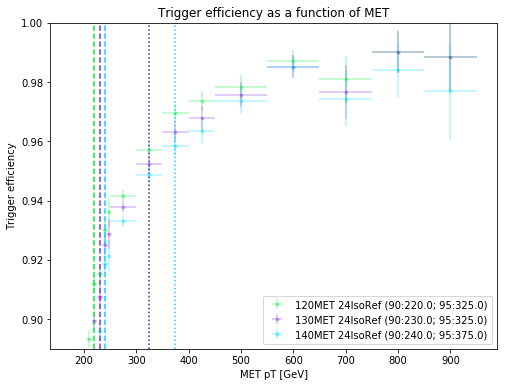

In [52]:
# Using cf (curve_fit), no x or y errors in the fit
#samples = full_samples
#samples = Combo_samples
samples=Comp_Data
sels = ['enrich']#,'enrichx']
sel_label = {'enrich1':'200'}#,'enrichx':'200_x25iso'}
for sel in sels:
    fig, ax = plt.subplots(figsize=(8,6))
    for index, (sample, props) in enumerate(samples.items()):
        scan_plot(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection=sel)
    fig.savefig(f'{web_dir}/scan_for_threshold.png', bbox_inches='tight')



In [ ]:
# Using cf (curve_fit), no x or y errors in the fit
#samples = full_samples
samples = Combo_samples
#samples = TT_samples
#samples = W_samples
#samples = Di_samples
sels = ['enrich','enrich1','enrichx','enrich1x']
sel_label = {'enrich':'200_x25','enrich1':'200_x50','enrichx':'200_x25iso','enrich1x':'200_x50iso'}
for sel in sels:
    fig, ax = plt.subplots(figsize=(8,6))
    for index, (sample, props) in enumerate(samples.items()):
        if props['label'] is 'TT':
            continue
        #make_plot_fit_cf(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='enrich1x')
        make_plot_fit_cf(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection=sel)
    #fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_full_{sel_label[sel]}.png', bbox_inches='tight')
    fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_combo_{sel_label[sel]}.png', bbox_inches='tight')



#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_TT.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_W.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_diboson.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_data.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_full_200_x25.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_full_200_x50.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_full_200_x25iso.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_full_200_x50iso.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_combo_200_x25.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_combo_200_x50.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_combo_200_x25iso.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_cf_combo_200_x50iso.png', bbox_inches='tight')

In [ ]:
# Using ODR, includes both x errors (bin width) and y errors
#samples = full_samples
samples = Combo_samples
#samples = TT_samples
#samples = W_samples
#samples = Di_samples
sels = ['enrich','enrich1','enrichx','enrich1x']
sel_label = {'enrich':'200_x25','enrich1':'200_x50','enrichx':'200_x25iso','enrich1x':'200_x50iso'}
for sel in sels:
    fig, ax = plt.subplots(figsize=(8,6))
    for index, (sample, props) in enumerate(samples.items()):
        if props['label'] is 'TT':
            continue
        make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection=sel)
        #make_plot_fit_odr(ax, sample, props, 'recoPFMetPt', eff_plots['recoPFMetPt'], event_selection='enrich1x')
    #fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_full_200_{sel_label[sel]}.png', bbox_inches='tight')
    fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_combo_200_{sel_label[sel]}.png', bbox_inches='tight')



#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_TT.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_W.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_diboson.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_data.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_full_200_x25.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_full_200_x50.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_full_200_x25iso.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_full_200_x50iso.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_combo_200_x25.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_combo_200_x50.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_combo_200_x25iso.png', bbox_inches='tight')
#fig.savefig(f'{web_dir}/trigger_vs_met_fit_preselected_ODR_combo_200_x50iso.png', bbox_inches='tight')

In [ ]:
for index, (sample, props) in enumerate(full_samples.items()):
    if props['label'] == 'TT':
        continue
    print(props)

# Trigger efficiency of `MET_120`  vs kinematic distributions -- all events

In [ ]:
#samples= full_samples
#info = pd.Dataframe()
sels = ['enrich','enrich1','enrichx','enrich1x']
sel_label= {'enrich': 'mu50trig, mu>25','enrich1': 'mu50trig, mu>50','enrichx': 'isomu24trig, mu>25','enrich1x': 'isomu24trig, mu>50'}
for sel in sels:
    df = {'labels' : [],'selection' : [], 'samples' :[],'samples>98odr' :[],'trig': [],'trig>98odr': [],'cf_98':[],'odr_98':[],'cf_eff':[],'odr_eff':[],'cf_chi2':[],'odr_chi2':[],'entries':[]}
    for index, (sample, props) in enumerate(full_samples.items()):
        if props['label'] == 'TT':
            continue
        df['labels'].append(props['label'])
        df['selection'].append(sel_label[sel])
        df['samples'].append(props[sel]['genwgt'].sum())
        df['samples>98odr'].append(props[sel][props[sel]['recoPFMetPt'] > props[sel]['odr_98']]['genwgt'].sum())
        df['trig'].append(props[sel][props[sel]['fired']==1]['genwgt'].sum())
        df['trig>98odr'].append(props[sel][(props[sel]['fired']==1) & (props[sel]['recoPFMetPt'] > props[sel]['odr_98'])]['genwgt'].sum())
        df['entries'].append(len(props[sel].index))
        df['cf_98'].append(props[sel]['cf_98'].iloc[0])
        df['odr_98'].append(props[sel]['odr_98'].iloc[0])
        df['cf_eff'].append(props[sel]['cf_eff'].iloc[0])
        df['odr_eff'].append(props[sel]['odr_eff'].iloc[0])
        df['cf_chi2'].append(props[sel]['cf_chi2'].iloc[0])
        df['odr_chi2'].append(props[sel]['odr_chi2'].iloc[0])
        print(props['label'],":",props[sel]['genwgt'].sum())
    #print(props['enrich'][props['enrich']['recoPFMetPt'] > props['odr_98']]['genwgt'].sum())
    for index, (sample, props) in enumerate(Combo_samples.items()):
        if props['label'] == 'MC':
            df['labels'].append(props['label'])
            df['selection'].append(sel_label[sel])
            df['samples'].append(props[sel]['genwgt'].sum())
            df['samples>98odr'].append(props[sel][props[sel]['recoPFMetPt'] > props[sel]['odr_98']]['genwgt'].sum())
            df['trig'].append(props[sel][props[sel]['fired']==1]['genwgt'].sum())
            df['trig>98odr'].append(props[sel][(props[sel]['fired']==1) & (props[sel]['recoPFMetPt'] > props[sel]['odr_98'])]['genwgt'].sum())
            df['entries'].append(len(props[sel].index))
            df['cf_98'].append(props[sel]['cf_98'].iloc[0])
            df['odr_98'].append(props[sel]['odr_98'].iloc[0])
            df['cf_eff'].append(props[sel]['cf_eff'].iloc[0])
            df['odr_eff'].append(props[sel]['odr_eff'].iloc[0])
            df['cf_chi2'].append(props[sel]['cf_chi2'].iloc[0])
            df['odr_chi2'].append(props[sel]['odr_chi2'].iloc[0])
            print(props['label'],":",props[sel]['genwgt'].sum())
    info = pd.DataFrame(df)
    info['pass'] = info['trig']/info['samples']
    info['pass>98'] = info['trig>98odr']/info['samples>98odr']
    print(info)

In [ ]:
df = {'labels' : [], 'samples' :[],'trig': [],'entries': []}
for index, (sample, props) in enumerate(Combo_samples.items()):
    df['labels'].append(props['label'])
    df['samples'].append(props['enrich']['genwgt'].sum())
    df['trig'].append(props['enrich'][props['enrich']['fired']==1]['genwgt'].sum())
    df['entries'].append(len(props['enrich'].index))
info = pd.DataFrame(df)
info['pass'] = info['trig']/info['samples']
print(info)